In [1]:
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys
import old_references.nonlinear_QM_FPJPA as Fs
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import standard_sequences.rabi as rabi
import standard_sequences.rabi_ef_swap as rabi_ef_swap
import standard_sequences.rabi_ef_no_swap as rabi_ef_no_swap
import standard_sequences.rabi_tomo as tomo
import classifiers.classifier as classifier
import analysis.analysis as analysis
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import joblib
import time
import traceback
from scipy.signal import savgol_filter

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)
 # offset to sweet spot

Qubit(qubit_thr=[-10000, -600], qubit_id=q1, ef_half_amp=1.3, ef_half_time=25, IQ_angle=60, ef_time=44, ge_ssm=-0.1144, RO_LO_pwr=16, ge_time=77, ge_amp=1.01, ro_amp=0.25, ro_freq=6.72739, RO_IF=None, ef_amp=1.5, ROIF=0.10268999999999995, ef_ssm=-0.25684, RO_LO=6.6247, ro_dur=5000, mixer_offset_ge=2.5, mixer_offset_ef=6)
Qubit(qubit_thr=[-10000, 1900], qubit_id=q2, ef_half_amp=None, ef_half_time=None, IQ_angle=25, ef_time=None, ge_ssm=-0.154, RO_LO_pwr=16, ge_time=74, ge_amp=0.4, ro_amp=0.45, ro_freq=6.65554, RO_IF=None, ef_amp=1, ROIF=0.030840000000000423, ef_ssm=-0.2962, RO_LO=6.6247, ro_dur=5000, mixer_offset_ge=None, mixer_offset_ef=None)


In [3]:
a_to_J = ((2 * np.pi) / (2 * (2 * q1.ef_time * 10**-3))) / q1.ef_amp
        # if J is in units of rad/micros
J_to_a = 1 / a_to_J

In [4]:
def correct_probabilities_over_time(M: np.ndarray,
                                    P_measured_mat: np.ndarray
                                   ) -> np.ndarray:
    """
    Perform constrained least-squares inversion on each column of P_measured_mat.
    
    Args:
        M:             (3×3) scale/assignment matrix.
        P_measured_mat:(3×N) measured probability columns.
    
    Returns:
        P_true_mat:   (3×N) corrected, physical probability columns.
    """
    num_levels, num_times = P_measured_mat.shape
    assert M.shape == (num_levels, num_levels), "M must be square of size 3"
    
    # Prepare output
    P_true_mat = np.zeros_like(P_measured_mat)
    
    # Common settings
    bounds = [(0, 1)] * num_levels
    constraint = {'type': 'eq', 'fun': lambda P: np.sum(P) - 1}

    # Loss function factory
    def make_loss(P_meas):
        return lambda P_true: np.linalg.norm(M @ P_true - P_meas)**2

    # Loop over each time index
    for i in range(num_times):
        P_meas = P_measured_mat[:, i]
        loss = make_loss(P_meas)
        x0 = np.ones(num_levels) / num_levels  # uniform initial guess
        
        res = minimize(loss,
                       x0,
                       bounds=bounds,
                       constraints=[constraint])
        
        if not res.success:
            raise RuntimeError(f"Optimization failed at column {i}: {res.message}")
        
        P_true_mat[:, i] = res.x
    
    return P_true_mat

In [ ]:
def run_rabi_tomo(
    q1,
    q2,
    general_vals_dict,
    num_steps: int,
    sweep_time: float,
    swap_freq: float,
    swap_time: float,
    reps: int,
    tomography: str,
    state:str,
    rabi_freq: float,
    drive_amp: float,
    y_phase: float,
    x_phase: float,
    load_sequence:int,
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    
    # Run the experiment
    if load_sequence == 0:
        pass
    elif load_sequence == 1:
        tomo.rabi_ef_swap_tomo(
        q1,
        q2,
        general_vals_dict,
        num_steps=num_steps,
        sweep_time=sweep_time,
        swap_freq=swap_freq,
        swap_time=swap_time,
        drive_amp=drive_amp,
        tomo_comp=tomography,
        state_comp=state,
        rabi_freq=rabi_freq,
        y_phase=y_phase,
        x_phase=x_phase,
        
    )
    

    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})

    # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
    classified = classifier.classify(IQ_df)
    states = classified["predicted"]
    # Reshape the predicted states.
    # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
    #  where each row corresponds to a time step and holds all the state measurements for that step.)
    states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
    probabilties = classifier.probabilities(states_reshaped)
    population = classifier.population(states_reshaped)

    # Compute time values as the index for the DataFrame.
    times = np.linspace(0, sweep_time / 1000, num_steps)

    # Build a DataFrame that holds the probability vs. time.
    df_prob = pd.DataFrame(
        {
            "time": times,
            "P_f": probabilties["P_f"],
            "P_e": probabilties["P_e"],
            "P_g": probabilties["P_g"],
        },
        index=times,
    )

    df_pop = pd.DataFrame(
        {
            "time": times,
            "Pop_f": population["Pop_f"],
            "Pop_e": population["Pop_e"],
            "Pop_g": population["Pop_g"],
        },
        index=times,
    )

    return df_prob, df_pop, values


def sweep_J(J_list: list):
    """
    Sweeps the frequency for the ef transition.
    For each frequency, it runs the experiment (via run_rabi_ef_swap) which returns a
    probability-vs-time DataFrame. Then it compiles these results into a dictionary
    where the keys are the frequency values (floats) and the values are the corresponding
    DataFrames.

    Returns:
        probability_dataframes (dict): A dictionary mapping frequency values to DataFrames.
            Each DataFrame has rows corresponding to time values (computed as
            np.linspace(0, sweep_time/1000, num_steps)) and columns for the state probabilities.
    """
    # Ensure the output directories exist

    probs_folder = os.path.join("sweep_J_data", "probs")
    values_folder = os.path.join("sweep_J_data", "values")
    os.makedirs(probs_folder, exist_ok=True)
    os.makedirs(values_folder, exist_ok=True)
    num_steps = 81
    reps = 8000
    sweep_time = 20000
    swap_freq = -0.0194
    swap_time = 0.5 * 7 / abs(swap_freq)

    # Create an array of frequency values
    J_vals = J_list

    # Initialize the dictionary with frequency keys set to None (or an empty placeholder)
    return_dict = {}
    return_vals = {}

    tomography="z"
    state="e"
    rabi_freq=q1.ef_ssm
    y_phase=0
    x_phase=0
    # Loop over frequencies and populate the dictionary
    for J in J_vals:
        prob_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")
        values_filename = os.path.join(values_folder, f"j={J:.3f}.pkl")

        # If both files already exist, load them and skip this iteration
        if os.path.exists(prob_filename) and os.path.exists(values_filename):
            with open(prob_filename, "rb") as f:
                df_prob = pickle.load(f)
            with open(values_filename, "rb") as f:
                values = pickle.load(f)
            return_dict[J] = df_prob
            return_vals[J] = values
            continue  # Skip to the next J value
        drive_amp = J * J_to_a
        tomography="z"
        state="e"
        rabi_freq=q1.ef_ssm
        y_phase=0
        x_phase=0
        load_sequence=1
        df_prob, df_pop, values = run_rabi_tomo(
            q1, q2, general_vals_dict,
            num_steps, sweep_time, swap_freq, swap_time,
            reps, tomography, state,
            rabi_freq, drive_amp, y_phase, x_phase,
            load_sequence
        )
        # Populate the dictionary at the corresponding frequency key
        return_dict[J] = df_prob
        return_vals[J] = values

        # Create filenames with the current J value
        prob_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")
        values_filename = os.path.join(values_folder, f"j={J:.3f}.pkl")

        # Save df_prob to a pickle file
        with open(prob_filename, "wb") as f:
            pickle.dump(df_prob, f)
            del df_prob
        # Save values to a pickle file
        with open(values_filename, "wb") as f:
            pickle.dump(values, f)
            del values
    return return_dict, return_vals

In [18]:
J_start = 0
J_stop = 1.5
J_steps = 151
# J_list = np.linspace(10, 10,1)#
J_list =[0,0.1,0.5] #np.linspace(J_start, J_stop, J_steps)
# Main loop: if an error occurs, print it, wait, and restart
while True:
    try:
        
        J_dict, vals_dict = sweep_J(J_list)
        break  # Exit loop when measurements complete successfully
    except Exception as e:
        print("An error occurred:")
        traceback.print_exc()
        print("Restarting in 5 seconds...")
        time.sleep(5)


writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 101
Records per pattern: 2000
Buffers per acquistion: 66
DAQ samples per pattern: 8192
An error occurred:
Restarting in 5 seconds...


Traceback (most recent call last):
  File "C:\Users\quantum1\AppData\Local\Temp\ipykernel_26996\56282952.py", line 10, in <module>
    J_dict, vals_dict = sweep_J(J_list)
                        ^^^^^^^^^^^^^^^
  File "C:\Users\quantum1\AppData\Local\Temp\ipykernel_26996\2848584650.py", line 163, in sweep_J
    df_prob, df_pop, values = run_rabi_tomo(
                              ^^^^^^^^^^^^^^
  File "C:\Users\quantum1\AppData\Local\Temp\ipykernel_26996\2848584650.py", line 55, in run_rabi_tomo
    values = daq.run_daq_het_2q(
             ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\quantum1\OneDrive\Documents\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\daq\daq_programs_homo.py", line 199, in run_daq_het_2q
    daq_alazar_homo.configure_board(alazar_params, board)
  File "c:\Users\quantum1\OneDrive\Documents\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\daq\daq_alazar_homo.py", line 84, in configure_board
    board.setCaptureClock(
  File "c:\User

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 101
Records per pattern: 2000
Buffers per acquistion: 66
DAQ samples per pattern: 8192
0, No error
Capturing 66 buffers. Press <enter> to abort
Capture completed in 21.429350 sec
Captured 66 buffers (3.079888 buffers per sec)
Captured 202752 records (9461.416069 records per sec)
Transferred 3321888768 bytes (155015840.876836 bytes per sec)
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loadin

In [34]:
probs_folder = os.path.join("sweep_J_data", "probs")
values_folder = os.path.join("sweep_J_data", "values")
scale_matrix= joblib.load("classifiers/scale_matrix.pkl")
probability_dataframes = {}
for J in J_list:
    prob_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")
    values_filename = os.path.join(values_folder, f"j={J:.3f}.pkl")

    # If both files already exist, load them and skip this iteration
    if os.path.exists(prob_filename) and os.path.exists(values_filename):
        with open(prob_filename, "rb") as f:
            df_prob = pickle.load(f)
            P_matrix=np.array([df_prob["P_g"], df_prob["P_e"], df_prob["P_f"]])
            P_matrix_scaled =correct_probabilities_over_time(scale_matrix, P_matrix)
            df_prob_scaled = pd.DataFrame(
                {
                    "time": df_prob["time"],
                    "P_f": P_matrix_scaled[2],
                    "P_e": P_matrix_scaled[1],
                    "P_g": P_matrix_scaled[0],
                },
                index=df_prob["time"],
            )

    probability_dataframes[J] = df_prob_scaled



In [29]:
def sweep_J_curve_fit(probability_dataframes):
    """
    Loops over each J in the probability_dataframes dictionary, performs a
    renormalization and curve fit on the P_f data, and returns a dictionary
    mapping J values to the extracted Rabi angular frequency.

    Parameters:
        probability_dataframes (dict): Dictionary with keys as J values and values as
                                       DataFrames containing columns 'time', 'P_f', 'P_e', etc.
        guess_gamma (float): Initial guess for gamma used in the curve fit for J <= 0.25.
        guess_freq (float): Initial guess for frequency used in the curve fit for J > 0.25.

    Returns:
        omega_values (dict): Dictionary mapping each J value to its extracted angular frequency
                             in rad/µs.
    """
    omega_values = {}

    for J, df in probability_dataframes.items():
        # Extract the time and state probability data from the DataFrame
        times = df["time"].values
        P_f = df["P_f"].values
        P_e = df["P_e"].values
        # print(J)
        # Renormalize: P_f_norm = P_f / (P_f + P_e)
        norm_factor = P_f + P_e
        # Avoid division by zero (if that case can ever occur)
        norm_factor[norm_factor == 0] = 1

        guess_gamma =np.sqrt( abs(0.14**2 - J**2))
        guess_freq = np.sqrt(abs(0.14**2 - J**2)) / np.pi
   
        if J <= 0.28:
            # Apply Savitzky-Golay filter
            window_length = 21  # must be odd; try 7, 9, 11, ...
            poly_order = 3     # polynomial order
            P_f_norm  = savgol_filter(P_f , window_length, poly_order)#P_f#/ norm_factor
            lower_bounds = [0, 0,0, 0, -np.inf]
            upper_bounds = [.01,0.6,np.inf, np.inf, np.inf]
            guess_vals = [0, .56,100, 0, 0.025]
        else:
            P_f_norm = P_f #/  norm_factor
            lower_bounds = [0, 0.4,0, -np.inf, -np.inf]
            upper_bounds = [.3,0.6,np.inf, np.inf, np.inf]
            guess_vals = [0, 0.5, (J/np.sqrt(abs(0.2**2 - J**2)) )**2, 0, 0.02]#0,0.55  , 
        # guess_vals = [0, guess_gamma, 0.1, -10, 0.03]
        # Perform the curve fit using analysis.fit_sine_decay.
        # It is assumed that this function returns a tuple where the first element
        # is an array of fit parameters, with the first parameter corresponding to frequency.
        fit_vals_f, _, _, _ = analysis.fit_sine_square_decay(
            times, P_f_norm, guess_vals=guess_vals,lower_bounds=lower_bounds,upper_bounds=upper_bounds
            
        )

        # Calculate the angular frequency: omega = |(freq * 2π)|
        omega_rabi_f = abs(fit_vals_f[0] * 2 * np.pi)

        print(f"J = {J}: Angular freq (rad/µs): {omega_rabi_f}")
        omega_values[J] = omega_rabi_f

    return omega_values

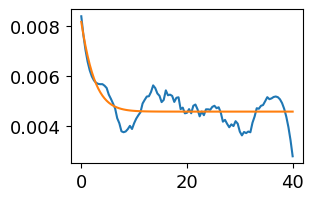

freq:0.009999973725668534,gamma: 0.5999999759939395, amp:0.014386477181271343, phase_deg: 29.91608959367317,offset: 0.004585267644214565,
J = 0: Angular freq (rad/µs): 0.06283168798530245


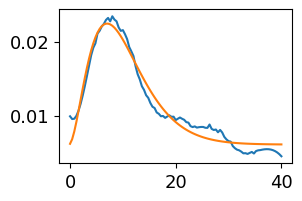

freq:0.007791371937158446,gamma: 0.26525770323719927, amp:0.8710359438038395, phase_deg: 0.6151118468463691,offset: 0.006123581164585325,
J = 0.1: Angular freq (rad/µs): 0.0489546336783253


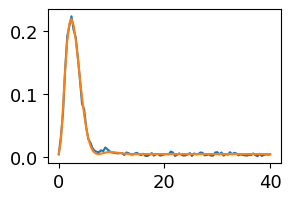

freq:0.06753216735567191,gamma: 0.5705799280742984, amp:1.19069252174932, phase_deg: -1.1078910420867878,offset: 0.005047984027889975,
J = 0.5: Angular freq (rad/µs): 0.42431712169115066
J = 0: omega = 0.06283168798530245 rad/µs
J = 0.1: omega = 0.0489546336783253 rad/µs
J = 0.5: omega = 0.42431712169115066 rad/µs


In [31]:
# probability_dataframes = 0
omega_dict = sweep_J_curve_fit(probability_dataframes)

# Print the results
for J, omega in omega_dict.items():
    print(f"J = {J}: omega = {omega} rad/µs")
J_vals = sorted(omega_dict.keys())
omegas = [omega_dict[J] for J in J_vals]




In [10]:
# plt.figure(figsize=(8, 6))
# plt.scatter(J_vals, omegas, marker="o")
# plt.xlabel("J")
# plt.ylabel("Angular Frequency (rad/µs)")
# plt.title("Angular Frequency vs. J")
# plt.grid(True)
# plt.show()

In [11]:
def fit_func(J, A, J0):
    """
    Model function: Re(A * sqrt(J - J0^2)).
    
    For each value in J, computes A*sqrt(J - J0^2) if J - J0^2 is nonnegative;
    otherwise returns 0.
    
    Parameters:
        J : array_like
            The independent variable.
        A : float
            Amplitude scaling factor.
        J0 : float
            Parameter inside the square root.
    
    Returns:
        array_like : The computed model values.
    """
    expr = J**2 - J0**2
    return np.where(expr >= 0, A * np.sqrt(expr), 0.0)

def curve_fit_function(J_data, y_data, initial_guess_A=1.0, initial_guess_J0=1.0):
    """
    Fits the data (J_data, y_data) to the function
         f(J) = Re(A * sqrt(J - J0^2))
    using the provided initial guesses for A and J0.
    
    Parameters:
        J_data : array_like
            The independent variable data.
        y_data : array_like
            The dependent variable data.
        initial_guess_A : float, optional
            Initial guess for the amplitude A (default is 1.0).
        initial_guess_J0 : float, optional
            Initial guess for the parameter J0 (default is 1.0).
    
    Returns:
        popt : ndarray
            Optimal values for the parameters [A, J0].
        pcov : 2D ndarray
            The estimated covariance of popt.
    """
    popt, pcov = curve_fit(fit_func, J_data, y_data, p0=[initial_guess_A, initial_guess_J0])
    return popt, pcov

def curve_fit_and_plot(J_data, y_data, initial_guess_A=1.0, initial_guess_J0=1.0):
    """
    Fits the given data to the model function f(J) = Re(A * sqrt(J - J0^2))
    and plots the original data (as a scatter plot) along with the fitted curve.
    
    Parameters:
        J_data : array_like
            The independent variable data.
        y_data : array_like
            The dependent variable data.
        initial_guess_A : float, optional
            Initial guess for the amplitude A (default is 1.0).
        initial_guess_J0 : float, optional
            Initial guess for the parameter J0 (default is 1.0).
    
    Returns:
        popt : ndarray
            The optimal parameters [A, J0] from the curve fitting.
        pcov : 2D ndarray
            The covariance matrix of the fitted parameters.
    """
    # Perform the curve fit
    popt, pcov = curve_fit_function(J_data, y_data, initial_guess_A, initial_guess_J0)
    fitted_A, fitted_J0 = popt
    print("Fitted A =", fitted_A)
    print("Fitted J0 =", fitted_J0)
    
    # Generate a smooth set of points for plotting the fitted curve
    J_fit = np.linspace(np.min(J_data), np.max(J_data), 1000)
    y_fit = fit_func(J_fit, fitted_A, fitted_J0)
    
    # Create the plot: scatter for original data and line for fitted curve
    plt.figure(figsize=(8, 5))
    plt.plot(J_fit, y_fit, label="Fitted Curve", color="red", linewidth=2)
    plt.scatter(J_data, y_data, label="Original Data", color="blue", s=30, alpha = .5)
    plt.xlabel("J")
    plt.ylabel("alpha=Re(A * sqrt(J^2 - J0^2))")
    plt.title("alpha vs J")
    plt.legend()
    # plt.grid(True)
    plt.show()
    
    return popt, pcov

In [12]:
# # Set initial guesses based on your expectations:
# initial_guess_J0 = 0.1  # for example
# initial_offset = 0.0  # for example
# mask_rb = ~np.isnan(omegas)
# # Assuming J_vals and omegas are defined and mask_rb selects the non-NaN entries.
# J_vals_array = np.array(J_vals)[mask_rb]
# omegas_array = np.array(omegas)[mask_rb]

# # Set your initial guess values
# initial_guess_J0 = 0.2# for example
# initial_guess_A0 = 1
# # Now, call your curve fitting and plotting function with the first 100 data points.
# popt, pcov = curve_fit_and_plot(J_vals_array, omegas_array, initial_guess_A0,initial_guess_J0)


<Figure size 960x720 with 0 Axes>

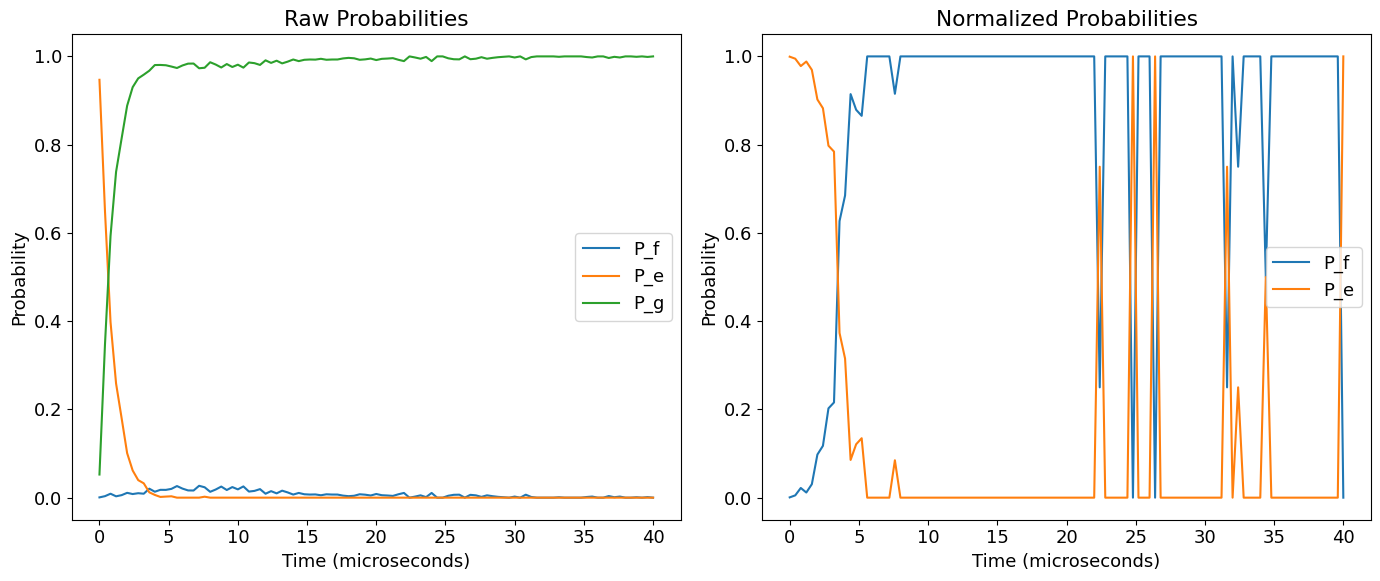

In [36]:
J = 0.1
df = probability_dataframes[J]  # This is your DataFrame for J=2

# Assuming probability_dataframes is the DataFrame loaded for J=2
# Extract the raw probabilities into an array (if needed)
measured_pop = np.array([
    df["P_g"],
    df["P_e"],
    df["P_f"]
])

# Compute normalization factor (using P_f and P_e)
normalization_val = df["P_f"] + df["P_e"]

# Create a new DataFrame with normalized probabilities
normalized_df = pd.DataFrame({
    "time": df["time"],
    "P_f": df["P_f"] / normalization_val,
    "P_e": df["P_e"] / normalization_val,
    "P_g": df["P_g"] / normalization_val,
})

# List of keys to plot
keys = ["P_f", "P_e", "P_g"]

# Create figure and two subplots
plt.figure(dpi=150)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot raw probabilities in the first subplot
for key in keys:
    sns.lineplot(data=df, x="time", y=key, ax=axes[0], label=key)

# Plot normalized probabilities in the second subplot (skip "P_g" if desired)
for key in keys:
    if key != "P_g":  # Plot only P_f and P_e for normalization if that’s your intention
        sns.lineplot(data=normalized_df, x="time", y=key, ax=axes[1], label=key)

# Set labels and titles for clarity
axes[0].set_xlabel("Time (microseconds)")
axes[0].set_ylabel("Probability")
axes[0].set_title("Raw Probabilities")
axes[0].legend()

axes[1].set_xlabel("Time (microseconds)")
axes[1].set_ylabel("Probability")
axes[1].set_title("Normalized Probabilities")
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()



In [14]:
# Define parameters
num_steps = 101
sweep_time = 40000  # in microseconds
J_start = 0        # starting J value
J_stop = 1.5       # ending J value
J_steps = 151       # number of J values

# Generate an array of J values
J_vals = np.linspace(J_start, J_stop, J_steps)

# Initialize a 2D array to store normalized P_f values
p_f = np.zeros((J_steps, num_steps))
p_f_norm = np.zeros((J_steps, num_steps))
# Loop over each J value, and calculate the normalized P_f
for i, J in enumerate(J_vals):
    probs_folder = os.path.join("sweep_J_data", "probs")
    pkl_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")

    with open(pkl_filename, "rb") as f:
        probability_dataframes = pickle.load(f)

      # This is your DataFrame for J=2
    # Access the DataFrame for the current J
    df = probability_dataframes
    
    # Compute normalized P_f using P_f / (P_f + P_e)
    p_f[i] = df["P_f"] #/ (df["P_f"] + df["P_e"])
    p_f_norm[i] = df["P_f"] / (df["P_f"] + df["P_e"])

# Create the 2D plot
plt.figure(dpi=150)
# extent: [x_min, x_max, y_min, y_max] where time is on x and J on y.
plt.imshow(p_f, extent=[0, sweep_time / 1000, J_stop, J_start], aspect="auto")
plt.colorbar()
plt.ylabel("J (rads/microseconds)")
plt.xlabel("Time (microseconds)")
plt.title("P_f")
plt.show()

plt.figure(dpi=150)
# extent: [x_min, x_max, y_min, y_max] where time is on x and J on y.
plt.imshow(p_f_norm, extent=[0, sweep_time / 1000, J_stop, J_start], aspect="auto")
plt.colorbar()
plt.ylabel("J (rads/microseconds)")
plt.xlabel("Time (microseconds)")
plt.title("P_f")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'sweep_J_data\\probs\\j=0.010.pkl'

In [ ]:
probability_dataframes

,time,P_f,P_e,P_g
0.0,0.0,0.011000,0.826833,0.162167
0.4,0.4,0.210167,0.385500,0.404333
0.8,0.8,0.460833,0.075167,0.464000
1.2,1.2,0.433333,0.080000,0.486667
1.6,1.6,0.201667,0.248000,0.550333
...,...,...,...,...
38.4,38.4,0.021333,0.002333,0.976333
38.8,38.8,0.018333,0.003000,0.978667
39.2,39.2,0.019500,0.002333,0.978167
39.6,39.6,0.023500,0.003667,0.972833


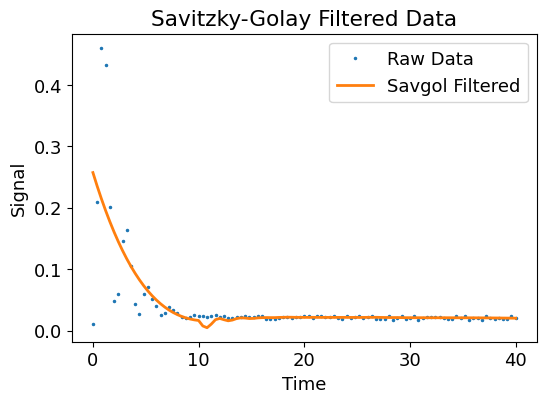

In [ ]:
# Apply Savitzky-Golay filter
window_length = 51  # must be odd; try 7, 9, 11, ...
poly_order =3     # polynomial order
y_filtered = savgol_filter(probability_dataframes["P_f"] , window_length, poly_order)

# Plot the filtered data
plt.figure(figsize=(6,4))
plt.plot(probability_dataframes["time"], probability_dataframes["P_f"], '.', label="Raw Data", markersize=3)
plt.plot(probability_dataframes["time"], y_filtered, '-', label="Savgol Filtered", linewidth=2)
plt.xlabel("Time")
plt.ylabel("Signal")
plt.title("Savitzky-Golay Filtered Data")
plt.legend()
plt.show()

<Figure size 960x720 with 0 Axes>

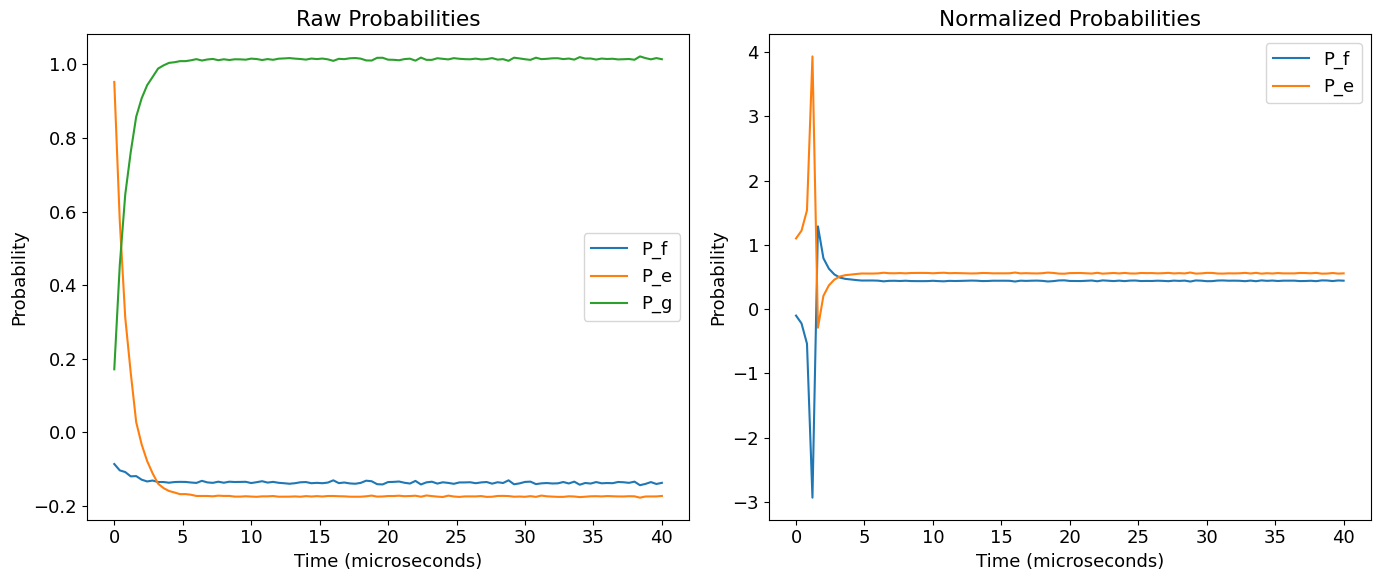

In [ ]:
scale_matrix = np.array([
    [0.96513333, 0.00563333, 0.02923333],
    [0.14921667, 0.8369,     0.01388333],
    [0.14105,    0.05938333, 0.79956667]
])
inv_matrix = np.linalg.inv(scale_matrix)
scaled_pop =np.matmul(inv_matrix,measured_pop )
scaled_df = pd.DataFrame({
    "time": probability_dataframes["time"],
    "P_f": scaled_pop[2],
    "P_e": scaled_pop[1],
    "P_g": scaled_pop[0],
})
# Compute normalization factor (using P_f and P_e)
normalization_val_scaled = scaled_pop[1]+scaled_pop[2]

# Create a new DataFrame with normalized probabilities
normalized_scaled_df = pd.DataFrame({
    "time": probability_dataframes["time"],
    "P_f": scaled_pop[2]/normalization_val_scaled,
    "P_e": scaled_pop[1]/normalization_val_scaled,
    "P_g": scaled_pop[0]/normalization_val_scaled,
})
# List of keys to plot
keys = ["P_f", "P_e", "P_g"]

# Create figure and two subplots
plt.figure(dpi=150)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot raw probabilities in the first subplot
for key in keys:
    sns.lineplot(data=scaled_df, x="time", y=key, ax=axes[0], label=key)

# Plot normalized probabilities in the second subplot (skip "P_g" if desired)
for key in keys:
    if key != "P_g":  # Plot only P_f and P_e for normalization if that’s your intention
        sns.lineplot(data=normalized_scaled_df, x="time", y=key, ax=axes[1], label=key)

# Set labels and titles for clarity
axes[0].set_xlabel("Time (microseconds)")
axes[0].set_ylabel("Probability")
axes[0].set_title("Raw Probabilities")
axes[0].legend()

axes[1].set_xlabel("Time (microseconds)")
axes[1].set_ylabel("Probability")
axes[1].set_title("Normalized Probabilities")
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [ ]:
# Initialize a dictionary to store the probability DataFrames for each J value
probability_dataframes = {}

# Loop over each J value and load the corresponding pickle file if it exists
for J in J_list:
    prob_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")
    values_filename = os.path.join(values_folder, f"j={J:.3f}.pkl")
    
    if os.path.exists(prob_filename) and os.path.exists(values_filename):
        with open(prob_filename, "rb") as f:
            df_prob = pickle.load(f)
        probability_dataframes[J] = df_prob
    else:
        print(f"Data for J = {J:.3f} not found. Skipping.")

# ---------------------------
# 2. Prepare Data for 2D Plotting
# ---------------------------

# Define parameters for the sweep
num_steps = 51      # number of time steps (should match what you used when saving the data)
sweep_time = 20000  # total sweep time in microseconds

# Initialize a 2D array to hold the normalized P_f values
p_f = np.zeros((J_steps, num_steps))

# For each J value, compute the normalized P_f as P_f / (P_f + P_e)
for i, J in enumerate(J_list):
    df = probability_dataframes.get(J)
    if df is not None:
        # Compute normalized P_f
        p_f[i] = df["P_f"] / (df["P_f"] + df["P_e"])
    else:
        # Fill with NaN if data is missing for a specific J
        p_f[i] = np.nan

# ---------------------------
# 3. Create the 2D Plot
# ---------------------------

plt.figure(dpi=150)
# The extent parameter maps the array indices to real data coordinates:
# [x_min, x_max, y_min, y_max]
plt.imshow(p_f, extent=[0, sweep_time/1000, J_stop, J_start], aspect="auto")
plt.colorbar(label="Normalized P_f")
plt.xlabel("Time (microseconds)")
plt.ylabel("J (rads/microseconds)")
plt.title("2D Heatmap of Normalized P_f vs Time and J")
plt.show()

ValueError: could not broadcast input array from shape (101,) into shape (51,)